The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

..\covid19_inference\plot.py:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if what is "data":
..\covid19_inference\plot.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif what is "fcast":
..\covid19_inference\plot.py:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif what is "model":


We read and work on a csv file containing the daily new hospitalisations from 18/03 to 30/04 in France.

In [3]:
import requests
import io

url = "https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20200430-190020/donnees-hospitalieres-nouveaux-covid19-2020-04-30-19h00.csv"

dataset = requests.get(url).content
hospitalisations = pd.read_csv(io.StringIO(dataset.decode('utf-8')), sep=";")

In [4]:
hospitalisations = hospitalisations.groupby("jour").sum()
hospitalisations = hospitalisations.drop(["incid_rea", "incid_dc", "incid_rad"], axis=1)

In [5]:
hospitalisations.index = pd.to_datetime(hospitalisations.index, format="%Y-%m-%d")

In [6]:
bd = hospitalisations.index[0]
ed = hospitalisations.index[-1]

new_cases_obs = hospitalisations.to_numpy().flatten()

date_begin_data = bd
date_end_data   = ed
diff_data_sim = 25 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_confinement_begin =  datetime.datetime(2020,3,17)
prior_date_easter_begin =  datetime.datetime(2020,4,11)
prior_date_easter_end = datetime.datetime(2020,4,13)

change_points = [dict(pr_mean_date_transient = prior_date_confinement_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_easter_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_easter_end,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [7]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 67e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=20, 
                                               pr_median_scale_delay=0.4)
    # higher delay because of use of hospitalisation data
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [8]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag', cores=1)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 371.81:  13%|██████▋                                            | 26399/200000 [03:48<25:01, 115.58it/s]
Convergence achieved at 26400
INFO     [pymc3.variational.inference] Convergence achieved at 26400
Interrupted at 26,399 [13%]: Average Loss = 429.52
INFO     [pymc3.variational.inference] Interrupted at 26,399 [13%]: Average Loss = 429.52
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_3, transient_day_2, transient_day_1, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_le

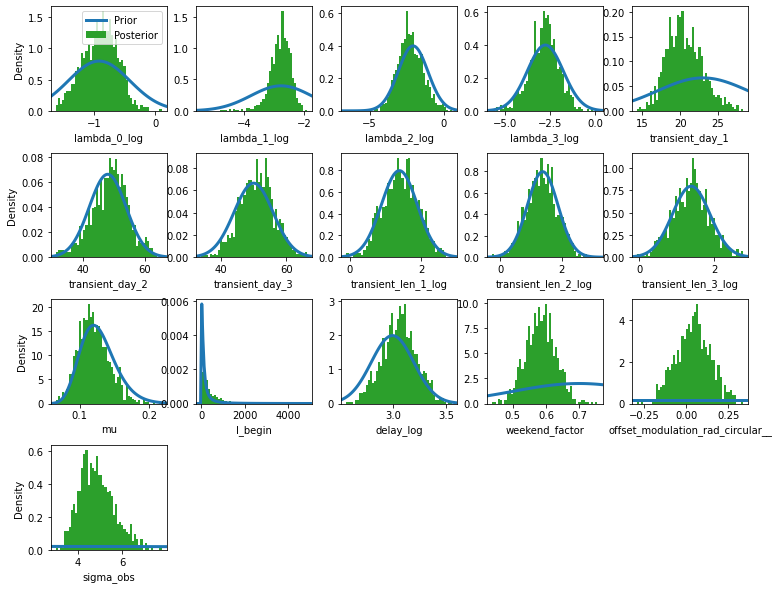

In [9]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

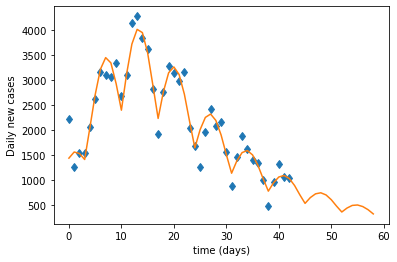

In [10]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

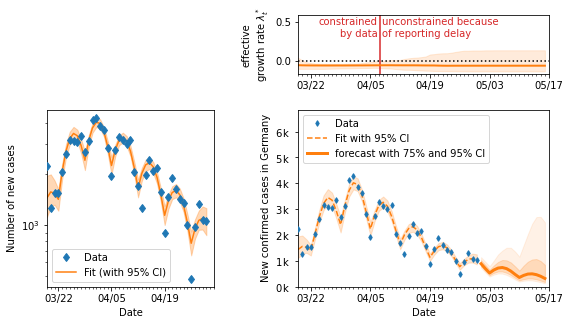

In [22]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim)

Replace Germany by France in your head!